# Nissen et al., 2023: Severe 21st-century OA in Antarctic MPAs
#
# Fig. 2: maps of anthropogenic carbon (top 200m and bottom layer)
#
# this script requires post-processed model output 

In [1]:
import sys
import os
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from scipy.interpolate import griddata
from matplotlib import cm
from netCDF4 import Dataset, MFDataset
import pandas as pd
import copy
from scipy import interpolate
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import matplotlib as mpl
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import matplotlib.path as mpath
from numpy.ma import masked_array
import matplotlib.colors


In [2]:
#------
# MODEL INFO
#------

# path to fields of anthropogenic carbon
path_to_data = '/pscratch/sd/c/cnissen/HLRN_runs_postprocessed/PAPER2_postprocessed/bottom_fields/' 

# path to masks of MPAs and ice-shelf cavities (on regular mesh; resolution currently hard-coded to be 0.025deg) 
# -> for contours only (can be easily turned off within plotting functions)
path_to_mask = '/pscratch/sd/c/cnissen/HLRN_runs_postprocessed/masks/masks_MPAs/'

savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/Paper_OA_in_MPAs/Fig2_maps_anthropogenic_carbon_corrected/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    
#---
# load mesh info
#---

path_mesh = '/pscratch/sd/c/cnissen/'
file_mesh = 'Nissen2022_FESOM_REcoM_mesh_information_corrected_20220910.nc'

f1 = Dataset(path_mesh+file_mesh) #xr.open_dataset(path+file1)
lat_model      = f1.variables['lat'][:]
lon_model      = f1.variables['lon'][:]
zlevs    = f1.variables['zlevs'][:]
cavities = f1.variables['cavity'][:]
topo     = f1.variables['topo'][:]
area     = f1.variables['cell_area'][:]
volume   = f1.variables['cell_volume'][:]
f1.close()
print(lat_model.shape)

ind_no_cavity = np.where(cavities==0)[0]
ind_cavities = np.where(cavities==1)[0]



(72411,)


In [3]:
#----
# define lat/lon -> plotting regular grid instead of native mesh
#----

grid_resolution_x = 0.1  #0.25 # define grid resolution of regular mesh
grid_resolution_y = 0.1 #0.0625
xi = np.arange(-180,180+grid_resolution_x,grid_resolution_x) #longitude
yi = np.arange(-90,40+grid_resolution_y,grid_resolution_y) #latitude

print ('Min/Max lon:',np.min(xi),np.max(xi))
print ('Min/Max lat:',np.min(yi),np.max(yi))
x_all,y_all = np.meshgrid(xi,yi)

print(x_all.shape)
lat_model

Min/Max lon: -180.0 179.99999999997954
Min/Max lat: -90.0 39.99999999999261
(1301, 3601)


masked_array(data=[ 77.98136 ,  78.02875 ,  78.015755, ..., -84.328026,
                   -84.258835, -84.307396],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [4]:
#----
# load bottom concentrations of DIC_anth
#----
      
#---
# 1990s
#---

f1   = Dataset(path_to_data+'DIC_anth_bottom_1990s_mumol_kg_fesom.nc') 
C_anth_bottom_1 = f1.variables['DIC_anth_bottom_1990s_mumol_kg'][:]
f1.close()
f1   = Dataset(path_to_data+'DIC_anth_1990s_top200m_mumol_kg_fesom.nc') 
C_anth_top2000_1 = f1.variables['DIC_anth_1990s_top200m_mumol_kg'][:]
f1.close()

print(C_anth_bottom_1.shape)

#---
# 2090s
#---
f1   = Dataset(path_to_data+'DIC_anth_bottom_2090s_mumol_kg_fesom.nc') 
C_anth_bottom_2 = f1.variables['DIC_anth_bottom_2090s_mumol_kg'][:]
f1.close()
f1   = Dataset(path_to_data+'DIC_anth_2090s_top200m_mumol_kg_fesom.nc')
C_anth_top2000_2 = f1.variables['DIC_anth_2090s_top200m_mumol_kg'][:]
f1.close()

print(C_anth_bottom_2.shape)
print(C_anth_bottom_1)
print(C_anth_top2000_1)


(72411,)
(72411,)
[5.055711  5.771521  3.571517  ... 6.4621134 6.4463825 6.4399333]
[7.388658  8.1787815 7.851396  ... 0.        0.        0.       ]


In [5]:
####
# interpolate to regular mesh
# 

lat_orig,lon_orig = lat_model,lon_model #mesh.y2, mesh.x2

def interpolate_fields(lat_orig,lon_orig,data,lat_final,lon_final):
    interp_method = 'cubic' # cubic, nearest, linear
    data_int = griddata((lon_orig,lat_orig),data,\
                (lon_final.ravel(), lat_final.ravel()), method=interp_method)  # Final interpolated field
    data_int = data_int.reshape((lon_final.shape[0],lon_final.shape[1])) 
    return data_int
    
#--------
print ('regrid C_anth data, 1990s')
C_anth_bottom_1_int = interpolate_fields(lat_orig,lon_orig,C_anth_bottom_1, y_all,x_all)
C_anth_top2000_1_int = interpolate_fields(lat_orig,lon_orig,C_anth_top2000_1, y_all,x_all)
print ('regrid C_anth data, 2090s')
C_anth_bottom_2_int = interpolate_fields(lat_orig,lon_orig,C_anth_bottom_2, y_all,x_all)
C_anth_top2000_2_int = interpolate_fields(lat_orig,lon_orig,C_anth_top2000_2, y_all,x_all)
#---------
print ('regrid topo')
topo_int = interpolate_fields(lat_orig,lon_orig,topo,y_all,x_all)
#--------
print ('regrid cavity info')
cav_int = interpolate_fields(lat_orig,lon_orig,cavities,y_all,x_all)
#--------
print ('done')


regrid C_anth data, 1990s
regrid C_anth data, 2090s
regrid topo
regrid cavity info
done


In [6]:
#----
# prepare data to plot
#----

data_plot1e = np.copy(C_anth_bottom_1_int)
data_plot2e = np.copy(C_anth_bottom_2_int)

data_plot1d = np.copy(C_anth_top2000_1_int)
data_plot2d = np.copy(C_anth_top2000_2_int)

data_topo = np.copy(topo_int)
data_cav = np.copy(cav_int)

# topo & sea ice
def correct_dateline_points(data):
    # for topo & sea ice: correct a few more longitudes to get smooth contour lines across the dateline
    data[:,3] = data[:,4]
    data[:,2] = data[:,3]
    data[:,1] = data[:,2]
    data[:,0] = data[:,1]
    data[:,-4] = data[:,-5]
    data[:,-3] = data[:,-4]
    data[:,-2] = data[:,-3]
    data[:,-1] = data[:,-2]
    return data
    
data_topo = correct_dateline_points(data_topo)

data_cav[:,1] = data_cav[:,2]
data_cav[:,0] = data_cav[:,1]
data_cav[:,-2] = data_cav[:,-3]
data_cav[:,-1] = data_cav[:,-2]

data1e, lon = add_cyclic_point(data_plot1e, coord=xi)
data2e, lon = add_cyclic_point(data_plot2e, coord=xi)

data1d, lon = add_cyclic_point(data_plot1d, coord=xi)
data2d, lon = add_cyclic_point(data_plot2d, coord=xi)

data2, lonxx = add_cyclic_point(data_topo, coord=xi)
del lonxx
data3, lonxx = add_cyclic_point(data_cav, coord=xi)
del lonxx
print (data2.shape)
print (data3.shape)


#----
# correct data in cavity etc
#----

# correct topo data on land
data2[data2<0]=-999
data2[np.isnan(data2)]=-999

# cavity field
data3[data3<0]=-999
data3[np.isnan(data3)]=-999

data1e[data1e<=0]=0
data2e[data2e<=0]=0
data3e=data2e-data1e

data1d[data1d<=0]=0
data2d[data2d<=0]=0
data3d=data2d-data1d

data2[data3>=0.5]=-999
print ('done')


(1301, 3602)
(1301, 3602)
done


In [7]:
#----
# FUNCTION for plotting
#-----

color_cavity = 'black' #'darkgrey'

dpicnt=200
fs = 12
lw = 1.5 # topography
lw2 = 1.0 # cavity

def plot_map_circumpolar_nonlinear_colorbar(data_plot,lon_plot,lat_plot,topo,levels1,cmap1,ctick1,\
                                    cticks_label,clabel_string,depth_label,\
                         save_plots,display_plots,savepath,filename1,path_to_mask):
    plot_colorbar = False
    fs = 10
    
    data_plot1 = np.copy(data_plot)
    data_plot1 = np.log10(data_plot1)
    data_plot1[data_plot1<levels1[0]] = levels1[0]+0.001
        
    # projection
    projection=ccrs.SouthPolarStereo()
    
    plot_MPAs = True
    color_mpa = (200./255.,200./255.,200./255.) #'white' #'black'
    lw_mpa = 2
    
    if plot_MPAs:
        which_res = '0.025'

        f1 = Dataset(path_to_mask+'MPA_mask_AntarcticPeninsula_regular_mesh_'+which_res+'deg.nc')
        mask_WAP_MPA = f1.variables['mask_mpa'][:]
        lon_MPA2 = f1.variables['lon'][:]
        lat_MPA2 = f1.variables['lat'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_1_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA1_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_2_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA2_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_3_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA3_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_Orkney_regular_mesh_'+which_res+'deg.nc')
        mask_Orkney_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_RossSea_regular_mesh_'+which_res+'deg.nc')
        mask_RossSea_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_WeddellSea_regular_mesh_'+which_res+'deg.nc')
        mask_WeddellSea_MPA = f1.variables['mask_mpa'][:]
        f1.close()

        f1 = Dataset(path_to_mask+'Mask_cavities_regular_mesh_'+which_res+'deg.nc')
        cav_int = f1.variables['mask_cavities'][:]
        f1.close()
        
        cav_int[cav_int.mask==True]=0

        mask_eastAA1_MPA[mask_eastAA1_MPA.mask==True]=0 #np.ma.masked_where()
        mask_eastAA2_MPA[mask_eastAA2_MPA.mask==True]=0
        mask_eastAA3_MPA[mask_eastAA3_MPA.mask==True]=0
        mask_WeddellSea_MPA[mask_WeddellSea_MPA.mask==True]=0
        mask_Orkney_MPA[mask_Orkney_MPA.mask==True]=0
        mask_RossSea_MPA[mask_RossSea_MPA.mask==True]=0
        mask_WAP_MPA[mask_WAP_MPA.mask==True]=0
        
        lon_MPA,lat_MPA = np.meshgrid(lon_MPA2,lat_MPA2)
        del lon_MPA2,lat_MPA2
            
        # correct mask so that it matches the mask used on FESOM mesh (see regrid_cavity_to_regular_mesh.ipynb)
        # for the Weddell Sea, connect piece at WAP tip with southern piece
        ind = np.where((lat_MPA<=-64.0) & (lon_MPA<-50) & (lon_MPA>-62.5)) #[0]
        # ind = np.where((lat_MPA<=-64.0) & (lon_MPA<310) & (lon_MPA>298.5)) #[0]
        mask_WeddellSea_MPA[ind]=1
        # correct piece that reaches into WAP
        ind = np.where((lat_MPA>-64.8) & (lon_MPA<-60)) #[0]
        # ind = np.where((lat_MPA >-64.8) & (lon_MPA<300)) #[0]
        mask_WeddellSea_MPA[ind]=0
            
        mask_eastAA1_MPA[cav_int==1]=0
        mask_eastAA2_MPA[cav_int==1]=0
        mask_eastAA3_MPA[cav_int==1]=0
        mask_WeddellSea_MPA[cav_int==1]=0
        mask_Orkney_MPA[cav_int==1]=0
        mask_RossSea_MPA[cav_int==1]=0
        mask_WAP_MPA[cav_int==1]=0
        
        print('min/max mask_MPA:',np.min(mask_WeddellSea_MPA),np.max(mask_WeddellSea_MPA))
        
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
    ax.coastlines(resolution='50m')
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # plot coastal
    mm1=ax.contourf(lon_plot, lat_plot, data_plot1,\
                   levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
    if plot_colorbar:
        cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.6,ticks=cticks1)
        cbar.set_label(clabel_string,fontsize=fs+5) #clabel_string
        cbar.ax.tick_params(labelsize=fs+4)
        cbar.ax.set_xticklabels(cticks_label)
        
    gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.5,\
                    color='grey', alpha=0.8,linestyle='--')#,xlabels_bottom=True)
    gl.top_labels = True
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels=True
    #gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-180,-120,-60,0,60,120]) 
    gl.ylocator = mticker.FixedLocator([-70,-65])
    #gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.rotate_labels = False

    lw = 2
    ax.contour(lon_plot, lat_plot, topo,levels = [2000],\
                     colors=['dimgrey','black','black'],linewidths=[lw+0.75,lw,lw],\
               linestyles=['-','-',':'],transform=ccrs.PlateCarree())
               
    #-----
    # add MPA contours
    if plot_MPAs:
        #print ('min/max lon_plot:',np.min(lon_plot),np.max(lon_plot))
        #print ('min/max lon_MPA:',np.min(lon_MPA),np.max(lon_MPA))
       
        m = np.zeros_like(mask_RossSea_MPA)
        m[:,0:8] = 1
        m[:,-8:-1] = 1
        mask_RossSea_MPA = np.ma.masked_array(mask_RossSea_MPA, m)
        
        m = np.zeros_like(mask_RossSea_MPA)
        m[0:400,:] = 1
        mask_WeddellSea_MPA = np.ma.masked_array(mask_WeddellSea_MPA, m)
        mask_WAP_MPA = np.ma.masked_array(mask_WAP_MPA, m)
        mask_RossSea_MPA = np.ma.masked_array(mask_RossSea_MPA, m)
        mask_eastAA1_MPA = np.ma.masked_array(mask_eastAA1_MPA, m)
        mask_eastAA2_MPA = np.ma.masked_array(mask_eastAA2_MPA, m)
        mask_eastAA3_MPA = np.ma.masked_array(mask_eastAA3_MPA, m)
        mask_Orkney_MPA  = np.ma.masked_array(mask_Orkney_MPA, m)
        
        ax.contour(lon_MPA, lat_MPA, mask_WeddellSea_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_WAP_MPA,levels = [lw_mpa],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_RossSea_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA1_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA2_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA3_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_Orkney_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        
    ## cavities
    #ax.contour(lon_MPA, lat_MPA, cav_int,levels = [0.5],\
    #                     colors=['gainsboro'],linewidths=[lw],linestyles=['-'],transform=ccrs.PlateCarree())
    # cavities
    ind_2 = np.where(lat_plot[:,0]>-75.0)[0]
    cav_int[0:400,:] = 1 # high-high-latitudes
    ind_s = 420
    cav_int[ind_s:,-5] =  -999
    cav_int[ind_s:,-4] =  -999
    cav_int[ind_s:,-3] =  -999
    cav_int[ind_s:,-2] =  -999
    cav_int[ind_s:,-1] =  -999
    cav_int[ind_s:,0]  =  -999
    cav_int[ind_s:,1]  =  -999
    cav_int[ind_s:,2]  =  -999
    cav_int[ind_s:,3]  =  -999
    cav_int[ind_s:,4]  =  -999
    
    m = np.zeros_like(cav_int)
    m[:,0:10] = 1
    m[:,-10:-1] = 1
    cav_int = np.ma.masked_array(cav_int, m)

    ax.contour(lon_MPA, lat_MPA, cav_int,levels = [0.5],\
                         colors=[(50./255.,50./255.,50./255.)],\
               linewidths=[lw],linestyles=['-'],transform=ccrs.PlateCarree())

    dpicnt = 200

    if save_plots:
        if plot_colorbar:
            filename = filename1+'.png'
        else:
            filename = filename1+'_no_colorbar.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
        del filename
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        
    #return lon_MPA, lat_MPA,cav_int
        

In [8]:
#----
# bottom
#----

/tmp/ipykernel_297639/2356137666.py:19: RuntimeWarning: divide by zero encountered in log10
  data_plot1 = np.log10(data_plot1)


min/max mask_MPA: 0.0 1.0


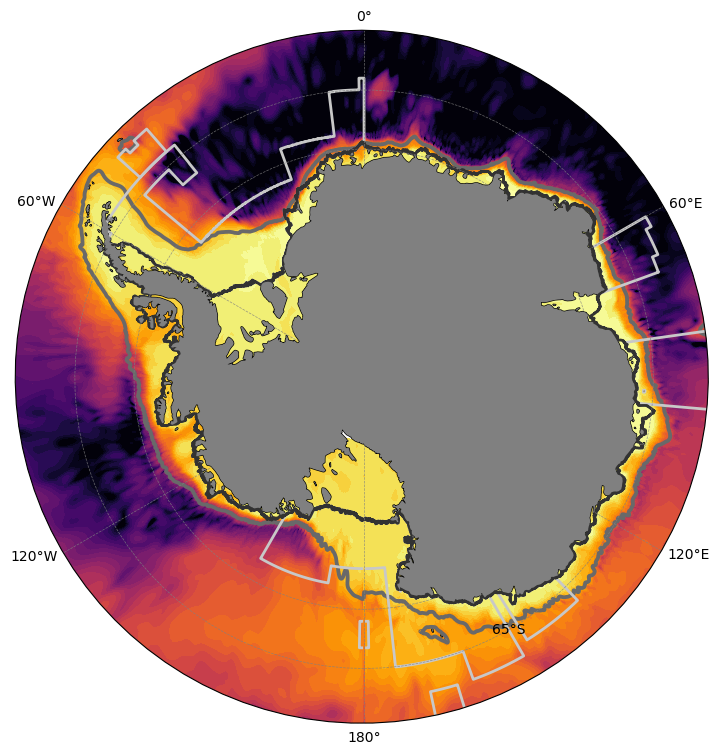

In [9]:
#-----
# try to find one colorbar that works for all
#-----
# see here for an example: 
# https://stackoverflow.com/questions/22128166/two-different-color-colormaps-in-the-same-imshow-matplotlib

#----
# plot: C_anth 1990s, bottom 
#----

lon_plot,lat_plot = np.meshgrid(lon,yi) 
save_plots = True
display_plots = True

# colormap
#cmap1 = copy.copy(plt.cm.Greens_r) #
cmap1 = copy.copy(plt.cm.inferno) #RdYlBu_r, BrBG_r
#cmap2 = copy.copy(plt.cm.PRGn)
#cmap1.set_under('white')


#----
# plot: C_anth 1990s, bottom, coast
#----
data_plot = np.copy(data1e)
data_plot[data_plot<=0]=0
data_plot = np.ma.masked_where(np.isnan(data_plot),data_plot)
data_plot[data_plot<0]=0 #-999

data_plot[:,-1] = data_plot[:,1]
data_plot[:,-2] = data_plot[:,1]
data_plot[:,-3] = data_plot[:,1]
data_plot[:,-4] = data_plot[:,1]

clabel_string = 'anthropogenic carbon in $\mu$mol kg$^{-1}$'
depth_label = 'bottom'
filename = 'Map_anthr_carbon_bottom_circumpolar_1990s_non_linear_colorbar_mumol_kg_v2'      

# first levels,cmap -> coastal
# second levels,cmap -> open ocean
#levels1a = np.arange(4.0,13.5,0.5) # bottom
#cticks1 = [4,6,8,10,12]
levels1a = np.arange(-2.0,1.1+0.1,0.1) # bottom
cticks1 = [np.log10(0.01),np.log10(0.03),np.log10(0.1),np.log10(0.3),np.log10(1),np.log10(3),np.log10(10)]
cticks_label = ['0.01','0.03','0.1','0.3','1','3','10'] 

plot_map_circumpolar_nonlinear_colorbar(data_plot,lon_plot,lat_plot,data2,\
                     levels1a,cmap1,cticks1,cticks_label,clabel_string,depth_label,\
                                save_plots,display_plots,savepath,filename,path_to_mask)


/tmp/ipykernel_297639/2356137666.py:19: RuntimeWarning: divide by zero encountered in log10
  data_plot1 = np.log10(data_plot1)


min/max mask_MPA: 0.0 1.0


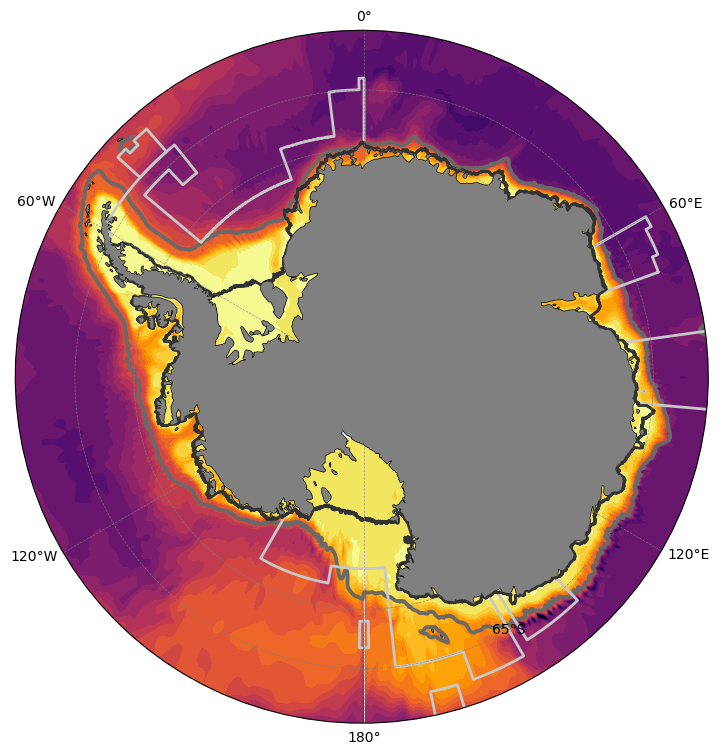

In [10]:
#----
# plot: C_anth 2090s, bottom, coast
#----
save_plots = True
display_plots = True

data_plot = np.copy(data2e)
data_plot[data_plot<=0]=0
data_plot = np.ma.masked_where(np.isnan(data_plot),data_plot)
data_plot[data_plot<0]=0 #-999

data_plot[:,-1] = data_plot[:,0]
data_plot[:,-2] = data_plot[:,0]
data_plot[:,-3] = data_plot[:,0]
data_plot[:,-4] = data_plot[:,0]

clabel_string = 'anthropogenic carbon in $\mu$mol kg$^{-1}$'
depth_label = 'bottom'
filename = 'Map_anthr_carbon_bottom_circumpolar_2090s_non_linear_colorbar_mumol_kg_v2'      

levels1a = np.arange(0,2.15+0.1,0.1)
cticks1 = [np.log10(1),np.log10(3),np.log10(10),\
          np.log10(30),np.log10(100)]
cticks_label = ['1','3','10','30','100'] 

plot_map_circumpolar_nonlinear_colorbar(data_plot,lon_plot,lat_plot,data2,\
                     levels1a,cmap1,cticks1,cticks_label,clabel_string,depth_label,\
                                save_plots,display_plots,savepath,filename,path_to_mask)


In [11]:
print(savepath)

/global/cfs/cdirs/m4003/cnissen/Plots/Paper_OA_in_MPAs/Fig2_maps_anthropogenic_carbon_corrected/


In [12]:
#----
# top 200m
#----

In [13]:
#----
# FUNCTION for plotting top200m
#-----

color_cavity = 'black' #'darkgrey'

dpicnt=200
fs = 12
lw = 1.5 # topography
lw2 = 1.0 # cavity

def plot_map_circumpolar_nonlinear_colorbar_color_cavity(data_plot,lon_plot,lat_plot,topo,levels1,cmap1,ctick1,\
                                    cticks_label,clabel_string,depth_label,\
                         save_plots,display_plots,savepath,filename1,path_to_mask):
    plot_colorbar = False
    fs = 10
    
    # create two masked arrays
    #data_plot1 = masked_array(data_plot,topo>2000)  # plot coastal
    #data_plot2 = masked_array(data_plot,topo<=2000) # plot open ocean
    # data to plot
    data_plot1 = np.copy(data_plot)
    data_plot1 = np.log10(data_plot1)
    data_plot1[data_plot1<levels1[0]] = levels1[0]+0.001
        
    # projection
    projection=ccrs.SouthPolarStereo()
    
    
    plot_MPAs = True
    color_mpa = (200./255.,200./255.,200./255.) #'white' #'black'
    lw_mpa = 2
    
    if plot_MPAs:
        which_res = '0.025'

        f1 = Dataset(path_to_mask+'MPA_mask_AntarcticPeninsula_regular_mesh_'+which_res+'deg.nc')
        mask_WAP_MPA = f1.variables['mask_mpa'][:]
        lon_MPA2 = f1.variables['lon'][:]
        lat_MPA2 = f1.variables['lat'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_1_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA1_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_2_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA2_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_3_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA3_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_Orkney_regular_mesh_'+which_res+'deg.nc')
        mask_Orkney_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_RossSea_regular_mesh_'+which_res+'deg.nc')
        mask_RossSea_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_WeddellSea_regular_mesh_'+which_res+'deg.nc')
        mask_WeddellSea_MPA = f1.variables['mask_mpa'][:]
        f1.close()

        f1 = Dataset(path_to_mask+'Mask_cavities_regular_mesh_'+which_res+'deg.nc')
        cav_int = f1.variables['mask_cavities'][:]
        f1.close()
        
        cav_int[cav_int.mask==True]=0

        mask_eastAA1_MPA[mask_eastAA1_MPA.mask==True]=0 #np.ma.masked_where()
        mask_eastAA2_MPA[mask_eastAA2_MPA.mask==True]=0
        mask_eastAA3_MPA[mask_eastAA3_MPA.mask==True]=0
        mask_WeddellSea_MPA[mask_WeddellSea_MPA.mask==True]=0
        mask_Orkney_MPA[mask_Orkney_MPA.mask==True]=0
        mask_RossSea_MPA[mask_RossSea_MPA.mask==True]=0
        mask_WAP_MPA[mask_WAP_MPA.mask==True]=0
        
        lon_MPA,lat_MPA = np.meshgrid(lon_MPA2,lat_MPA2)
        del lon_MPA2,lat_MPA2
            
        # correct mask so that it matches the mask used on FESOM mesh (see regrid_cavity_to_regular_mesh.ipynb)
        # for the Weddell Sea, connect piece at WAP tip with southern piece
        ind = np.where((lat_MPA<=-64.0) & (lon_MPA<-50) & (lon_MPA>-62.5)) #[0]
        # ind = np.where((lat_MPA<=-64.0) & (lon_MPA<310) & (lon_MPA>298.5)) #[0]
        mask_WeddellSea_MPA[ind]=1
        # correct piece that reaches into WAP
        ind = np.where((lat_MPA>-64.8) & (lon_MPA<-60)) #[0]
        # ind = np.where((lat_MPA >-64.8) & (lon_MPA<300)) #[0]
        mask_WeddellSea_MPA[ind]=0
            
        mask_eastAA1_MPA[cav_int==1]=0
        mask_eastAA2_MPA[cav_int==1]=0
        mask_eastAA3_MPA[cav_int==1]=0
        mask_WeddellSea_MPA[cav_int==1]=0
        mask_Orkney_MPA[cav_int==1]=0
        mask_RossSea_MPA[cav_int==1]=0
        mask_WAP_MPA[cav_int==1]=0
        
        print('min/max mask_MPA:',np.min(mask_WeddellSea_MPA),np.max(mask_WeddellSea_MPA))
        
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
    ax.coastlines(resolution='50m')
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # plot coastal
    mm1=ax.contourf(lon_plot, lat_plot, data_plot1,\
                   levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
    if plot_colorbar:
        cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.6,ticks=cticks1)
        cbar.set_label(clabel_string,fontsize=fs+5) #clabel_string
        cbar.ax.tick_params(labelsize=fs+4)
        cbar.ax.set_xticklabels(cticks_label)
        
    gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.5,\
                    color='grey', alpha=0.8,linestyle='--')#,xlabels_bottom=True)
    gl.top_labels = True
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels=True
    #gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-180,-120,-60,0,60,120]) 
    gl.ylocator = mticker.FixedLocator([-70,-65])
    #gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.rotate_labels = False

    lw = 2
    ax.contour(lon_plot, lat_plot, topo,levels = [2000],\
                     colors=['dimgrey','black','black'],linewidths=[lw+0.75,lw,lw],\
               linestyles=['-','-',':'],transform=ccrs.PlateCarree())
               
    #-----
    # add MPA contours
    if plot_MPAs:
        #print ('min/max lon_plot:',np.min(lon_plot),np.max(lon_plot))
        #print ('min/max lon_MPA:',np.min(lon_MPA),np.max(lon_MPA))
       
        m = np.zeros_like(mask_RossSea_MPA)
        m[:,0:8] = 1
        m[:,-8:-1] = 1
        mask_RossSea_MPA = np.ma.masked_array(mask_RossSea_MPA, m)
        
        m = np.zeros_like(mask_RossSea_MPA)
        m[0:400,:] = 1
        mask_WeddellSea_MPA = np.ma.masked_array(mask_WeddellSea_MPA, m)
        mask_WAP_MPA = np.ma.masked_array(mask_WAP_MPA, m)
        mask_RossSea_MPA = np.ma.masked_array(mask_RossSea_MPA, m)
        mask_eastAA1_MPA = np.ma.masked_array(mask_eastAA1_MPA, m)
        mask_eastAA2_MPA = np.ma.masked_array(mask_eastAA2_MPA, m)
        mask_eastAA3_MPA = np.ma.masked_array(mask_eastAA3_MPA, m)
        mask_Orkney_MPA  = np.ma.masked_array(mask_Orkney_MPA, m)
        
        ax.contour(lon_MPA, lat_MPA, mask_WeddellSea_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_WAP_MPA,levels = [lw_mpa],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_RossSea_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA1_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA2_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA3_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_Orkney_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        
    ## cavities
    #ax.contour(lon_MPA, lat_MPA, cav_int,levels = [0.5],\
    #                     colors=['gainsboro'],linewidths=[lw],linestyles=['-'],transform=ccrs.PlateCarree())
    # cavities
    ind_2 = np.where(lat_plot[:,0]>-75.0)[0]
    cav_int[0:400,:] = 1 # high-high-latitudes
    ind_s = 420
 #   cav_int[ind_s:,-5] =  -999
 #   cav_int[ind_s:,-4] =  -999
 #   cav_int[ind_s:,-3] =  -999
 #   cav_int[ind_s:,-2] =  -999
 #   cav_int[ind_s:,-1] =  -999
 #   cav_int[ind_s:,0]  =  -999
 #   cav_int[ind_s:,1]  =  -999
 #   cav_int[ind_s:,2]  =  -999
 #   cav_int[ind_s:,3]  =  -999
 #   cav_int[ind_s:,4]  =  -999
    
    m = np.zeros_like(cav_int)
    m[:,0:10] = 1
    m[:,-10:-1] = 1
    cav_int = np.ma.masked_array(cav_int, m)
    cav_int = np.ma.masked_where(np.isnan(cav_int),cav_int)
    cav_int = np.ma.masked_where(cav_int==-999,cav_int)
    #print(np.min(cav_int),np.max(cav_int),cav_int)

    ax.contourf(lon_MPA, lat_MPA, cav_int,levels = [0.5,1],\
                         colors=[(218./255.,228./255.,238./255.)],\
               linewidths=[lw],linestyles=['-'],transform=ccrs.PlateCarree())
    ax.contour(lon_MPA, lat_MPA, cav_int,levels = [0.5],\
                         colors=[(50./255.,50./255.,50./255.)],\
               linewidths=[lw],linestyles=['-'],transform=ccrs.PlateCarree())
    
    #colors2 = matplotlib.colors.ListedColormap([(218./255.,228./255.,238./255.),(218./255.,228./255.,238./255.),\
    #                                        (218./255.,228./255.,238./255.),(218./255.,228./255.,238./255.)])
    
    #levels1 = np.arange(0,3,1)
    #mm2=ax.contourf(lon_MPA, lat_MPA, cav_int,\
    #           levels=levels1,extend='both',cmap=colors2,transform=ccrs.PlateCarree())
    # gainsboro
    #-----
    
    #ax.contour(lon_plot, lat_plot, data_plot_ice1,levels = [0.15],\
    #                 colors=['black'],linewidths=[lw],linestyles=['-'],transform=ccrs.PlateCarree())
    #ax.contour(lon_plot, lat_plot, data_plot_ice2,levels = [0.15],\
    #                 colors=['black'],linewidths=[lw],linestyles=['--'],transform=ccrs.PlateCarree())
    #ax.contour(lon_plot, lat_plot, data_plot_ice3,levels = [0.15],\
    #                 colors=['black'],linewidths=[lw],linestyles=[':'],transform=ccrs.PlateCarree())

    #ax.annotate('all between '+str(depth1)+'-'+str(depth2)+'m',xy=(0.29,0.012),\
    #            xycoords='axes fraction',style='italic',fontsize=fs,ha='right',color='k') #fontweight='bold'

    dpicnt = 200

    save_plots = True
    if save_plots:
        if plot_colorbar:
            filename = filename1+'.png'
        else:
            filename = filename1+'_no_colorbar.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
        del filename
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        
    return cav_int
        
    #return lon_MPA, lat_MPA,cav_int
        

/tmp/ipykernel_297639/3903587111.py:23: RuntimeWarning: divide by zero encountered in log10
  data_plot1 = np.log10(data_plot1)


min/max mask_MPA: 0.0 1.0


/global/common/software/nersc/pe/conda-envs/23.10.0/python-3.11/nersc-python/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


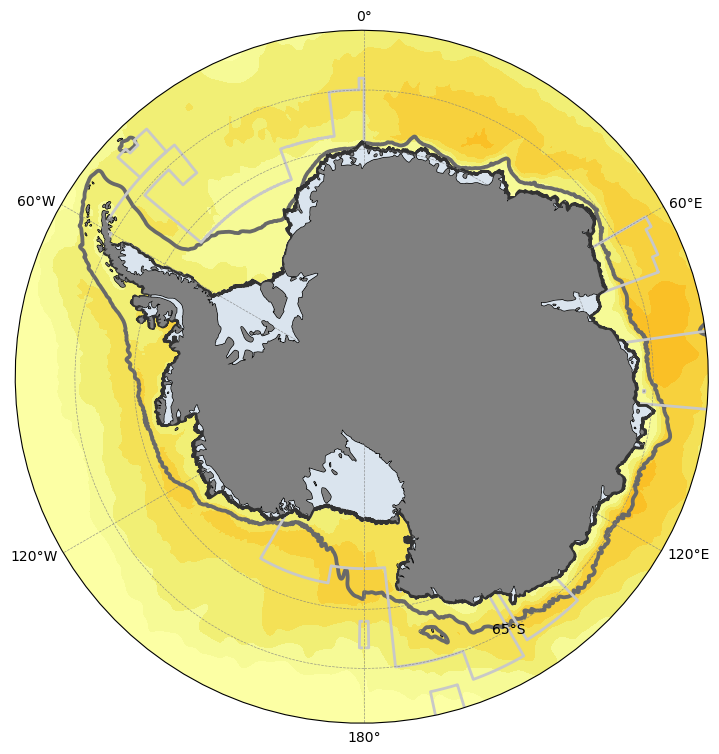

In [14]:
#----
# plot: C_anth 1990s, top200m
#----

lon_plot,lat_plot = np.meshgrid(lon,yi) 
save_plots = True
display_plots = True

# colormap
cmap1 = copy.copy(plt.cm.inferno) #RdYlBu_r, BrBG_r

#----
# plot: C_anth 1990s, top 2000 m, coast
#----
data_plot = np.copy(data1d)
data_plot[data_plot<=0]=0
data_plot = np.ma.masked_where(np.isnan(data_plot),data_plot)
data_plot[data_plot<0]=0 #-999

data_plot[:,-1] = data_plot[:,1]
data_plot[:,-2] = data_plot[:,1]
data_plot[:,-3] = data_plot[:,1]
data_plot[:,-4] = data_plot[:,1]

clabel_string = 'anthropogenic carbon in $\mu$mol kg$^{-1}$'
depth_label = 'top 200m average' #'top 2000m average'
filename = 'Map_anthr_carbon_top200m_avg_circumpolar_1990s_non_linear_colorbar_mumol_kg_v2'      

levels1a = np.arange(-2.0,1.1+0.1,0.1) # bottom
cticks1 = [np.log10(0.01),np.log10(0.03),np.log10(0.1),np.log10(0.3),np.log10(1),np.log10(3),np.log10(10)]
cticks_label = ['0.01','0.03','0.1','0.3','1','3','10'] 

data_plot = np.ma.masked_where(data_plot<0.01,data_plot)
cav_int = plot_map_circumpolar_nonlinear_colorbar_color_cavity(data_plot,lon_plot,lat_plot,data2,\
                     levels1a,cmap1,cticks1,cticks_label,clabel_string,depth_label,\
                                save_plots,display_plots,savepath,filename,path_to_mask)


/tmp/ipykernel_297639/3903587111.py:23: RuntimeWarning: divide by zero encountered in log10
  data_plot1 = np.log10(data_plot1)


min/max mask_MPA: 0.0 1.0


/global/common/software/nersc/pe/conda-envs/23.10.0/python-3.11/nersc-python/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


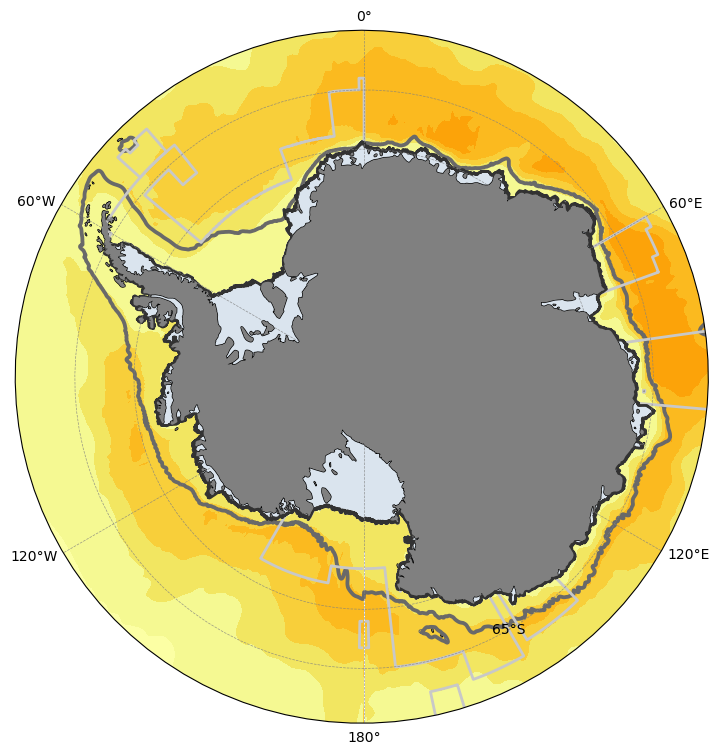

masked_array(
  data=[[--, --, --, ..., --, --, 1.0],
        [--, --, --, ..., --, --, 1.0],
        [--, --, --, ..., --, --, 1.0],
        ...,
        [--, --, --, ..., --, --, 0.0],
        [--, --, --, ..., --, --, 0.0],
        [--, --, --, ..., --, --, 0.0]],
  mask=[[ True,  True,  True, ...,  True,  True, False],
        [ True,  True,  True, ...,  True,  True, False],
        [ True,  True,  True, ...,  True,  True, False],
        ...,
        [ True,  True,  True, ...,  True,  True, False],
        [ True,  True,  True, ...,  True,  True, False],
        [ True,  True,  True, ...,  True,  True, False]],
  fill_value=9.96921e+36,
  dtype=float32)

In [15]:
#----
# plot: C_anth 2090s, top 200m
#----

lon_plot,lat_plot = np.meshgrid(lon,yi) 
save_plots = True
display_plots = True

# colormap
cmap1 = copy.copy(plt.cm.inferno) 

data_plot = np.copy(data2d)
data_plot[data_plot<=0]=0
data_plot = np.ma.masked_where(np.isnan(data_plot),data_plot)
data_plot[data_plot<0]=0 #-999

data_plot[:,-1] = data_plot[:,0]
data_plot[:,-2] = data_plot[:,0]
data_plot[:,-3] = data_plot[:,0]
data_plot[:,-4] = data_plot[:,0]

clabel_string = 'anthropogenic carbon in $\mu$mol kg$^{-1}$'
depth_label = 'top 200m average' #'top 2000m average'
filename = 'Map_anthr_carbon_top200m_avg_circumpolar_2090s_non_linear_colorbar_mumol_kg_v2'   

levels1a = np.arange(0,2.15+0.1,0.1)
cticks1 = [np.log10(1),np.log10(3),np.log10(10),\
          np.log10(30),np.log10(100)]
cticks_label = ['1','3','10','30','100'] 

data_plot = np.ma.masked_where(data_plot<0.01,data_plot)
plot_map_circumpolar_nonlinear_colorbar_color_cavity(data_plot,lon_plot,lat_plot,data2,\
                     levels1a,cmap1,cticks1,cticks_label,clabel_string,depth_label,\
                                save_plots,display_plots,savepath,filename,path_to_mask)


In [16]:
#----
# colorbars only
#----

In [17]:
#----
# FUNCTION for plotting
#-----

color_cavity ='darkgrey'

dpicnt=200
fs = 12
lw = 1.5 # topography
lw2 = 1.0 # cavity

def plot_map_circumpolar_non_linear_colorbar_only(data_plot,lon_plot,lat_plot,topo,levels1,cmap1,ctick1,\
                                    cticks_label,clabel_string,depth_label,\
                         save_plots,display_plots,savepath,filename1):
    plot_colorbar = False
    fs = 10
    
    data_plot1 = np.copy(data_plot)
    data_plot1 = np.log10(data_plot1)
    data_plot1[data_plot1<levels1[0]] = levels1[0]+0.001
        
    # projection
    projection=ccrs.SouthPolarStereo()

    #---
    # eps
    #---
    plot_eps = True
    if plot_eps:
        print('eps...')

        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(1, 1, 1, projection=projection)
        ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
        ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
        ax.coastlines(resolution='50m')
        # Compute a circle in axes coordinates, which we can use as a boundary
        # for the map. We can pan/zoom as much as we like - the boundary will be
        # permanently circular.
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)

        # plot coastal
        mm1=ax.contourf(lon_plot, lat_plot, data_plot1,\
                       levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
        plt.gca().set_visible(False)
        cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.6,ticks=cticks1)
        cbar.ax.tick_params(labelsize=fs+4)
        cbar.ax.set_xticklabels(['']*len(cticks1))
        #cbar.ax.set_xticklabels(cticks_label)

        dpicnt = 200

        save_plots = True
        if save_plots:
            plt.savefig(savepath+filename1+'_colorbar_only.eps',dpi = dpicnt, bbox_inches='tight',format='eps')
        if display_plots:
            plt.show()
        else:
            plt.close(fig)
        
        
    #---
    # png
    #---
    print('png...')
    
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
    ax.coastlines(resolution='50m')
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # plot coastal
    mm1=ax.contourf(lon_plot, lat_plot, data_plot1,\
                   levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
    plt.gca().set_visible(False)
    cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.6,ticks=cticks1)
    cbar.set_label(clabel_string,fontsize=fs+5) #clabel_string
    cbar.ax.tick_params(labelsize=fs+4)
    cbar.ax.set_xticklabels(cticks_label)

    dpicnt = 200

    save_plots = True
    if save_plots:
        plt.savefig(savepath+filename1+'_colorbar_only.png',dpi = dpicnt, bbox_inches='tight')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        
        
        

/tmp/ipykernel_297639/678598369.py:19: RuntimeWarning: divide by zero encountered in log10
  data_plot1 = np.log10(data_plot1)


eps...


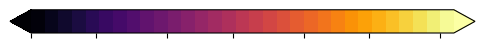

png...


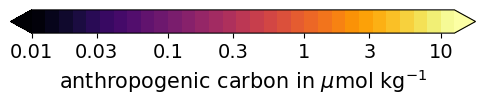

In [18]:
#----
# plot: C_anth 1990s, top200m
# COLORBAR ONLY
#----

lon_plot,lat_plot = np.meshgrid(lon,yi) 
save_plots = True
display_plots = True

# colormap
cmap1 = copy.copy(plt.cm.inferno) 

#----
# plot: C_anth 1990s, top 2000 m, coast
#----
data_plot = np.copy(data1d)
data_plot[data_plot<=0]=0
data_plot = np.ma.masked_where(np.isnan(data_plot),data_plot)
data_plot[data_plot<0]=0 #-999

data_plot[:,-1] = data_plot[:,1]
data_plot[:,-2] = data_plot[:,1]
data_plot[:,-3] = data_plot[:,1]
data_plot[:,-4] = data_plot[:,1]

clabel_string = 'anthropogenic carbon in $\mu$mol kg$^{-1}$'
depth_label = 'top 200m average' 
filename = 'Map_anthr_carbon_top200m_avg_circumpolar_1990s_non_linear_colorbars_mumol_kg' 

levels1a = np.arange(-2.0,1.1+0.1,0.1) # bottom
cticks1 = [np.log10(0.01),np.log10(0.03),np.log10(0.1),np.log10(0.3),np.log10(1),np.log10(3),np.log10(10)]
cticks_label = ['0.01','0.03','0.1','0.3','1','3','10'] 

plot_map_circumpolar_non_linear_colorbar_only(data_plot,lon_plot,lat_plot,data2,\
                     levels1a,cmap1,cticks1,cticks_label,clabel_string,depth_label,\
                                save_plots,display_plots,savepath,filename)



/tmp/ipykernel_297639/678598369.py:19: RuntimeWarning: divide by zero encountered in log10
  data_plot1 = np.log10(data_plot1)


eps...


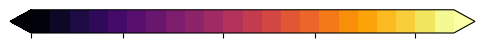

png...


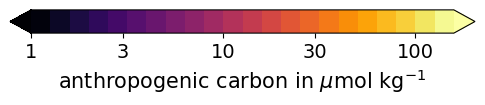

In [19]:
#----
# plot: C_anth 2090s, top 200m
# COLORBAR ONLY
#----
save_plots = True
display_plots = True

data_plot = np.copy(data2d)
data_plot[data_plot<=0]=0
data_plot = np.ma.masked_where(np.isnan(data_plot),data_plot)
data_plot[data_plot<0]=0 #-999

data_plot[:,-1] = data_plot[:,0]
data_plot[:,-2] = data_plot[:,0]
data_plot[:,-3] = data_plot[:,0]
data_plot[:,-4] = data_plot[:,0]

clabel_string = 'anthropogenic carbon in $\mu$mol kg$^{-1}$'
depth_label = 'top 200m average' 
filename = 'Map_anthr_carbon_top200m_avg_circumpolar_2090s_non_linear_colorbars_mumol_kg'    

levels1a = np.arange(0,2.15+0.1,0.1)
cticks1 = [np.log10(1),np.log10(3),np.log10(10),\
          np.log10(30),np.log10(100)]
cticks_label = ['1','3','10','30','100'] 

plot_map_circumpolar_non_linear_colorbar_only(data_plot,lon_plot,lat_plot,data2,\
                     levels1a,cmap1,cticks1,cticks_label,clabel_string,depth_label,\
                                save_plots,display_plots,savepath,filename)

